<center>
    
    Neural Networks and Backpropagation
    
    Author: Daniel Coble
</center>

We now know enough to talk about multilayer perceptrons and and neural networks. As we saw in the gradient descent notebook, gradient descent is the normal algorithm for how a machine 'learns'. But for gradient descent to work, there needs to be an algorithm to efficiently calculate gradients. That algorithm is backpropagation. This notebook will cover neural networks and how backpropagation through neural networks works, and implementing an MLP by hand. That'll involve some in-depth calculation, which is annoying. When doing actual machine learning, we don't have to do that and can just use an ML library.
But it's good to have an understanding of what's going on under the hood. Then we can move on and never have to worry about backpropagation ever again.

A neural network layer is a transform from $\mathbb{R}^n$ to $\mathbb{R}^m$ and consists of an affine transform (linear transform with a bias), then an activation function applied elementwise to the vector.
$$ \text{Layer = affine transform + activation function} $$
$$\phi(x) = \sigma(Wx+b) $$

The matrix and vector $W$ and $b$ are the weights and bias of the NN layer (sometimes they are both called weights) and parameterize the function $\phi$. $W$ and $b$ are like the $\beta$ in linear regression, and it's the goal of training to find the optimal weights. Thing of the weights as a way to parameterize the function we are learning. A single-layer NN isn't too useful, rather they are stacked on top of each other to make (hence the name 'layer'). Consider the layer functions $\phi_1: \mathbb{R}^{i} \rightarrow \mathbb{R}^{h_1}$, $\phi_2: \mathbb{R}^{h_1} \rightarrow \mathbb{R}^{h_2}$, $\phi_3: \mathbb{R}^{h_2} \rightarrow \mathbb{R}$.
$$ \phi_1(x) = \sigma(W_1x+b_1) $$
$$ \phi_2(x) = \sigma(W_2x+b_2) $$
$$ \phi_3(x) = W_3x+b_3 $$
We removed the activation function from $\phi_3$ because it bounds the output between 0 and 1, which isn't desirable. A 3-layer MLP is
$$ \phi(x) = \phi_3(\phi_2(\phi_1(x))) = \sigma\left(W_3\sigma\left(W_2\sigma\left(W_1x+b_1\right) + b_2\right)+b_3\right) $$
and the weights of the entire NN which need to be optimized are $\mathbb{W} = \{W_1,W_2,W_3,b_1,b_2,b_3\}$. For future reference, let's also define the following vectors. 
$$ \xi_1 = W_1x + b_1$$
$$ \xi_2 = W_2\phi_1 + b_2 $$
For simplicity I will surpress the dependence of $\phi_1$, $\phi_2$, and $\phi_3$. We can now work through how the gradient of loss with respect to the weights is calculated with backpropagation. Let a dataset be $\{(x_i, y_i)\}_{i=1}^N$. Loss is mean squared error.
$$ L(\mathbb{W}) = \frac{1}{N}\sum_{i=1}^N \left(\phi(x_i)-y_i\right)^2 $$
Backpropagation is called that because it works in the opposite direction of inference: where in inference $\phi_1$ is caculated, then $\phi_2$, then $\phi_3$, in backpropagation, the gradient with respect to the weights of $\phi_3$ is calculated first, then $\phi_2$, then $\phi_1$. The principle of backpropagation is the chain rule. As the first step, we have to calculate the gradients $\frac{\partial L}{\partial W_3}$, $\frac{\partial L}{\partial b_3}$, and $\frac{\partial L}{\partial \phi_2}$. The first two are used for weight updating and the last is used to continue backpropagation. As convention, we'll have the numerator of the partial derivative always be a scalar, and if the denominator is a matrix or vector, take that as short hand for the matrix/vector of the same shape of the partial derivative of each element. The following equations are correct, and I don't blame you if you just want to take my word for that.
$$ \frac{\partial L}{\partial \phi_{3,i}} = \frac{2}{N}\left(\phi_{3,i}-y_i\right) $$
$$ \frac{\partial L}{\partial W_3} = \sum_{i=1}^N\frac{\partial L}{\partial \phi_{3,i}}\phi_{2,i}^T $$
$$ \frac{\partial L}{\partial b_3} = \sum_{i=1}^N\frac{\partial L}{\partial \phi_{3,i}} $$
$$ \frac{\partial L}{\partial \phi_{2,i}} = \left(\frac{\partial L}{\partial \phi_{3,i}}^T W\right)^T $$
This solves the third layer. The second layer is identical, except we also have to work through the activation function.
$$ \frac{\partial L}{\partial \xi_{2,i}} = \mathrm{diag}\left(\sigma'\left(\xi_{2,i}\right)\right)\frac{\partial L}{\partial \phi_{2,i}} $$
$$ \frac{\partial L}{\partial W_2} = \sum_{i=1}^N\frac{\partial L}{\partial \xi_{2,i}}\phi_{1,i}^T $$
$$ \frac{\partial L}{\partial b_2} = \sum_{i=1}^N\frac{\partial L}{\partial \xi_{2,i}} $$
$$ \frac{\partial L}{\partial \phi_{1,i}} = \left(\frac{\partial L}{\partial \xi_{2,i}}^T W\right)^T $$
And again for the first layer.
$$ \frac{\partial L}{\partial \xi_{1,i}} = \mathrm{diag}\left(\sigma'\left(\xi_{1,i}\right)\right)\frac{\partial L}{\partial \phi_{1,i}} $$
$$ \frac{\partial L}{\partial W_1} = \sum_{i=1}^N\frac{\partial L}{\partial \xi_{1,i}}x_{i}^T $$
$$ \frac{\partial L}{\partial b_1} = \sum_{i=1}^N\frac{\partial L}{\partial \xi_{1,i}} $$
This is a mess and frankly it sucks. On the bright side it's actually very nice. It's really not that much work to calculate the gradients with respect to all weights, which enables us to do gradient descent for problems of much larger dimension than we did in the Gradient Descent notebook. 

Resources:

[Wikipedia, Backpropagation](https://en.wikipedia.org/wiki/Backpropagation)

Now let's program all of this. This example will emphasize how NNs can approximate a generic function by sampling from that function. I've created a 2D function below, first let's plot it and create a dataset by sampling from it.

<IPython.core.display.Javascript object>


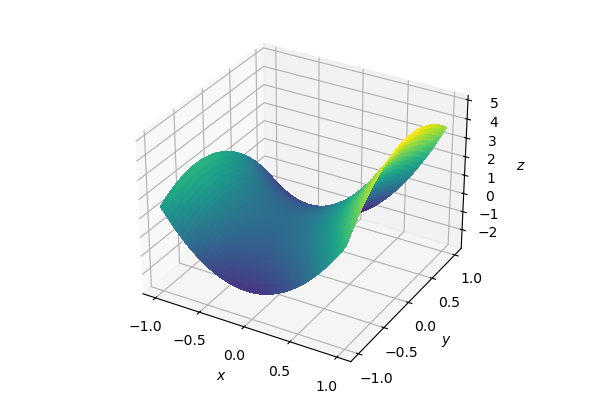

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

def f(x, y):
    return 3.5*x**2 + 1.1*x*y - 2*y**2 + 1.5*x -.4*y

x_bound = [-1, 1]
y_bound = [-1, 1]

# plot of f
fig, ax = plt.subplots(figsize=(6, 4), subplot_kw=dict(projection='3d'))
ax.set_box_aspect([1, 1, .75])

x_axis = np.linspace(x_bound[0], x_bound[1], 100)
y_axis = np.linspace(y_bound[0], y_bound[1], 100)

x_mesh, y_mesh = np.meshgrid(x_axis, y_axis)
z_mesh = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        z_mesh[i,j] = f(x_mesh[i,j], y_mesh[i,j])
ax.plot_surface(x_mesh, y_mesh, z_mesh, cmap='viridis', antialiased=False)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.tight_layout()

# sample from f in a 20x20 grid shape
x_axis = np.linspace(x_bound[0], x_bound[1], 20)
y_axis = np.linspace(y_bound[0], y_bound[1], 20)
x_mesh, y_mesh = np.meshgrid(x_axis, y_axis)
f_mesh = np.zeros((20, 20))
for i in range(20):
    for j in range(20):
        f_mesh[i,j] = f(x_mesh[i,j], y_mesh[i,j])

# reformat dataset into array of samples
# samples
X = np.append(x_mesh.reshape(-1, 1, 1), y_mesh.reshape(-1, 1, 1), axis=1)
y = f_mesh.reshape(-1, 1, 1)
n_samples = X.shape[0]

Now let's build the NN.

In [2]:
# sigmoid activation and its derivative
def sigmoid(x):
    return 1/(1+np.exp(-x))

def ddsigmoid(x):
    return np.exp(-x)/(1+np.exp(-x))**2
# input, output, and hidden layer dimensions
i_0 = 2
h_1 = 50
h_2 = 50
o_3 = 1
# initialize weights randomly
W_1 = np.random.normal(size=(h_1, i_0))
W_2 = np.random.normal(size=(h_2, h_1))
W_3 = np.random.normal(size=(o_3, h_2))
b_1 = np.random.normal(size=(h_1, 1))
b_2 = np.random.normal(size=(h_2, 1))
b_3 = np.random.normal(size=(o_3, 1))

'''
As we saw in the Gradient Descent notebook, it takes multiple gradient descent steps to reach a minimum. In machine learning
terminology, one complete pass through a dataset is called an epoch. To keep things simple and follow the derivation above,
we'll do one gradient descent step at each epoch. For larger datasets, that's impractical. Typically a gradient descent step
is calculated per each 'minibatch', a set of the samples from an epoch (it's often 64 samples). That strategy is called 
stochastic gradient descent and it allows more frequent weight updates, in turn allowing the model to converge quicker.
'''
n_epochs = 400
learning_rate = 0.02
loss_per_epoch = np.zeros(n_epochs) # record loss at each epoch
for i_epoch in range(n_epochs):
    # forward pass
    xi_1_mat = np.zeros((n_samples, h_1, 1))
    xi_2_mat = np.zeros((n_samples, h_2, 1))
    phi_1_mat = np.zeros((n_samples, h_1, 1))
    phi_2_mat = np.zeros((n_samples, h_2, 1))
    phi_3_mat = np.zeros((n_samples, o_3, 1))
    
    L = 0 # sum of loss per epoch
    for i_sample in range(n_samples):
        x = X[i_sample]
        y_ = y[i_sample]
        
        xi_1 = W_1@x + b_1
        phi_1 = sigmoid(xi_1)
        xi_2 = W_2@phi_1 + b_2
        phi_2 = sigmoid(xi_2)
        phi_3 = W_3@phi_2 + b_3
        
        xi_1_mat[i_sample] = xi_1
        xi_2_mat[i_sample] = xi_2
        phi_1_mat[i_sample] = phi_1
        phi_2_mat[i_sample] = phi_2
        phi_3_mat[i_sample] = phi_3
        
        L += 1/n_samples*((phi_3-y_)[0,0])**2
    
    loss_per_epoch[i_epoch] = L
    # backpropagation
    ddxi_1_mat = np.zeros((n_samples, h_1, 1))
    ddxi_2_mat = np.zeros((n_samples, h_2, 1))
    ddphi_1_mat = np.zeros((n_samples, h_1, 1))
    ddphi_2_mat = np.zeros((n_samples, h_2, 1))
    ddphi_3_mat = np.zeros((n_samples, o_3, 1))
    
    # gradients will be summed into these matrices
    ddW_3 = np.zeros(W_3.shape)
    ddW_2 = np.zeros(W_2.shape)
    ddW_1 = np.zeros(W_1.shape)
    ddb_3 = np.zeros(b_3.shape)
    ddb_2 = np.zeros(b_2.shape)
    ddb_1 = np.zeros(b_1.shape)
    
    for i_sample in range(n_samples):
        x = X[i_sample]
        xi_1 = xi_1_mat[i_sample]
        xi_2 = xi_2_mat[i_sample]
        phi_1 = phi_1_mat[i_sample]
        phi_2 = phi_2_mat[i_sample]
        phi_3 = phi_3_mat[i_sample]
        y_ = y[i_sample]
        
        ddphi_3 = 2/n_samples*(phi_3-y_)
        ddphi_2 = W_3.T@ddphi_3
        ddxi_2 = ddphi_2*ddsigmoid(xi_2)
        ddphi_1 = W_2.T@ddxi_2
        ddxi_1 = ddphi_1*ddsigmoid(xi_1)
        # add to the weight gradient summations
        ddW_3 += ddphi_3@(phi_2.T)
        ddb_3 += ddphi_3
        ddW_2 += ddxi_2@(phi_1.T)
        ddb_2 += ddxi_2
        ddW_1 += ddxi_1@(x.T)
        ddb_1 += ddxi_1
    # weight updating
    W_1 -= learning_rate*ddW_1
    W_2 -= learning_rate*ddW_2
    W_3 -= learning_rate*ddW_3
    b_1 -= learning_rate*ddb_1
    b_2 -= learning_rate*ddb_2
    b_3 -= learning_rate*ddb_3

Plot loss per epoch to show convergence.

<IPython.core.display.Javascript object>


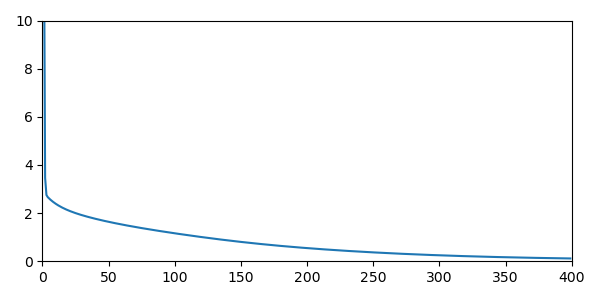

In [3]:
plt.figure(figsize=(6,3))
plt.plot(loss_per_epoch)
plt.xlim((0, n_epochs))
plt.ylim((0, 10))
plt.tight_layout()

Now let's plot the true and neural network functions to compare the two.

<IPython.core.display.Javascript object>


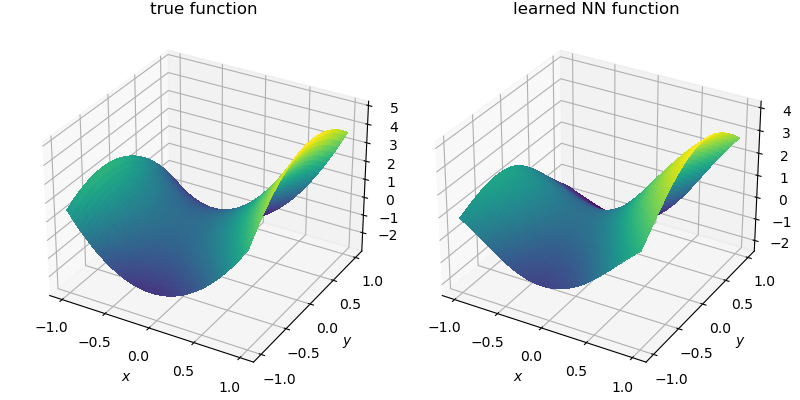

In [4]:
def NN_forward_pass(x, y):
    x = np.array([x, y]).reshape(2,1)
    
    xi_1 = W_1@x + b_1
    phi_1 = sigmoid(xi_1)
    xi_2 = W_2@phi_1 + b_2
    phi_2 = sigmoid(xi_2)
    phi_3 = W_3@phi_2 + b_3

    xi_1_mat[i_sample] = xi_1
    xi_2_mat[i_sample] = xi_2
    phi_1_mat[i_sample] = phi_1
    phi_2_mat[i_sample] = phi_2
    phi_3_mat[i_sample] = phi_3
    
    return phi_3[0,0]

x_bound = [-1, 1]
y_bound = [-1, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), subplot_kw=dict(projection='3d'))

x_axis = np.linspace(x_bound[0], x_bound[1], 100)
y_axis = np.linspace(y_bound[0], y_bound[1], 100)

x_mesh, y_mesh = np.meshgrid(x_axis, y_axis)
f_true_mesh = np.zeros((100, 100))
f_NN_mesh = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        f_true_mesh[i,j] = f(x_mesh[i,j], y_mesh[i,j])
        f_NN_mesh[i,j] = NN_forward_pass(x_mesh[i,j], y_mesh[i,j])

ax1.plot_surface(x_mesh, y_mesh, f_true_mesh, cmap='viridis', antialiased=False)
ax2.plot_surface(x_mesh, y_mesh, f_NN_mesh, cmap='viridis', antialiased=False)
ax1.set_title('true function')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_zlabel('$z$')
ax2.set_title('learned NN function')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_zlabel('$z$')
plt.tight_layout()

**Challenge Problem**

1. Modify the code above to use to use a ReLU activation function. What do you notice about the resultant model when you plot it?

2. Modify the code so that $h_1$ and $h_2$ are 15, 20, 50, 100, and 200. Plot how the error changes with the size of the layer.

To do (1), take the `relu` and `ddrelu` functions from the Activation Functions notebook, and replace calls to `sigmoid` and `ddsigmoid` with them. You may notice that the resultant model looks like a "crumpled napkin" (a piecewise linear function), rather than smooth like the sigmoid function.

The easiest way to do (2) would be to place the training function code in a for-loop, changing `h_1` and `h_2` with each loop. Record the error and plot it.